In [6]:
import json
import pandas as pd
import random
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

In [7]:
def load_jsonl(file_path):
    """Load a JSONL file into a DataFrame."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [8]:
def evaluate_priming(model, prime_tokens, good_tokens, bad_tokens, device):
    # This function receives already tokenized and tensorized 'prime_tokens', 'good_tokens', and 'bad_tokens',
    # all of which are expected to be on the specified 'device'.
    
    # Concatenate prime tokens with good and bad tokens for contextual influence
    primed_good_tokens = torch.cat((prime_tokens, good_tokens), dim=1)
    primed_bad_tokens = torch.cat((prime_tokens, bad_tokens), dim=1)

    # Calculate log likelihood for good and bad sentences with priming
    log_likelihood_good = calculate_log_likelihood(model, primed_good_tokens)
    log_likelihood_bad = calculate_log_likelihood(model, primed_bad_tokens)

    # Calculate log likelihood for good and bad sentences without priming (control)
    log_likelihood_good_control = calculate_log_likelihood(model, good_tokens)
    log_likelihood_bad_control = calculate_log_likelihood(model, bad_tokens)

    # Compute the priming effect as the change in likelihood difference due to priming
    delta_original = log_likelihood_good_control - log_likelihood_bad_control
    delta_primed = log_likelihood_good - log_likelihood_bad
    # delta_bad =  log_likelihood_bad - log_likelihood_bad_control
    # delta_good = log_likelihood_good - log_likelihood_good_control
    

    priming_effect = delta_primed - delta_original
    return priming_effect

def calculate_log_likelihood(model, tokens):
    # Assumes that the model has a method to calculate or return the loss when provided with input and labels
    # Here, we use the tokens as both input and labels, typical for language model training and evaluation
    with torch.no_grad():
        outputs = model(tokens, labels=tokens)
        loss = outputs.loss
        log_likelihood = -loss.item()  # Negating the loss to get log likelihood
    return log_likelihood
def evaluate_dataset(model, tokenizer, dataset, prime_sentence, device, batch_size=16):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    prime_tokens = tokenizer.encode(prime_sentence, return_tensors='pt').to(device)

    good_tokens = [tokenizer.encode(data['sentence_good'], return_tensors='pt').squeeze(0) for _, data in dataset.iterrows()]
    bad_tokens = [tokenizer.encode(data['sentence_bad'], return_tensors='pt').squeeze(0) for _, data in dataset.iterrows()]

    good_padded = pad_sequence(good_tokens, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    bad_padded = pad_sequence(bad_tokens, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)

    data_loader = DataLoader(TensorDataset(good_padded, bad_padded), batch_size=batch_size, shuffle=False)

    results = []
    for good_batch, bad_batch in data_loader:
        # Repeat prime_tokens to match batch size and concatenate
        repeated_prime_tokens = prime_tokens.repeat(good_batch.size(0), 1)
        effect = evaluate_priming(model, repeated_prime_tokens, good_batch, bad_batch, device)
        results.append(effect)  # Append the float directly

    mean_priming_effect = sum(results) / len(results)
    return mean_priming_effect


def main():
    # Load pre-trained GPT-2 model and tokenizer
    model_name = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    
    # Check if GPU is available and set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the device
    
    path = "./sorted_data/"
    # pss = { "Let me tell you a wild story.", "I just heard the crazyest thing.", "You won't believe this.", "I can't believe this happened.", "This is the craziest thing I've ever heard."}
    # for prime_sentence in pss:
    prime_sentence = "Let me tell you a wild story."    

    results = {}
    
    # Access each file and append the results
    results = {}
    target_dirs = ['sem', 'morp','synsem','syn']  # Directories of interest
    # target_dirs = ['sem', 'morp','syn','synsem']  # Directories of interest
    for root, dirs, files in os.walk(path):
        # Filter directories to only include those we're interested in
        dirs[:] = [d for d in dirs if d in target_dirs]
        for dir in dirs:
            current_path = os.path.join(root, dir)
            results[dir] = []
            print(f"Folder {dir} begins")
            for _, _, files in os.walk(current_path):
                for file in tqdm(files):
                    if 'checkpoint' in file:
                        continue
                    dataset_path = os.path.join(current_path, file)
                    dataset = load_jsonl(dataset_path)
                    result = evaluate_dataset(model, tokenizer, dataset, prime_sentence, device)
                    print(result)
                    results[dir].append(result)
    
    # Load existing results and update them
    if os.path.exists('results.json'):
        with open('results.json', 'r') as f:
            existing_results = json.load(f)
        existing_results.update(results)
        results = existing_results
    
    with open('results.json', 'w') as f:
        json.dump(results, f)

    return results

In [9]:
if __name__ == "__main__":
    main()

c:\Users\jindd\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Folder morp begins


  6%|▌         | 1/18 [00:03<00:59,  3.48s/it]

-0.08672737696814159


 11%|█         | 2/18 [00:06<00:53,  3.37s/it]

-0.09716697723146468


 17%|█▋        | 3/18 [00:10<00:49,  3.32s/it]

-0.22617893370371017


 22%|██▏       | 4/18 [00:13<00:46,  3.29s/it]

-0.22570252040075878


 28%|██▊       | 5/18 [00:16<00:44,  3.43s/it]

-0.11326095036097936


 33%|███▎      | 6/18 [00:20<00:40,  3.39s/it]

-0.17170099228147476


 39%|███▉      | 7/18 [00:24<00:39,  3.57s/it]

-0.12081118235512385


 44%|████▍     | 8/18 [00:30<00:45,  4.52s/it]

-0.1188665268913148


 50%|█████     | 9/18 [00:37<00:47,  5.29s/it]

-0.09604625853281172


 56%|█████▌    | 10/18 [00:44<00:45,  5.70s/it]

-0.09998624286954365


 61%|██████    | 11/18 [00:51<00:43,  6.28s/it]

-0.023085306561182416


 67%|██████▋   | 12/18 [00:59<00:39,  6.63s/it]

-0.002438825274270678


 72%|███████▏  | 13/18 [01:05<00:31,  6.37s/it]

-0.01353205574883355


 78%|███████▊  | 14/18 [01:10<00:24,  6.16s/it]

-0.04713708635360476


 83%|████████▎ | 15/18 [01:17<00:18,  6.31s/it]

-0.049613377404591395


 89%|████████▉ | 16/18 [01:23<00:12,  6.12s/it]

-0.11356968349880642


 94%|█████████▍| 17/18 [01:28<00:06,  6.01s/it]

-0.051698790656195745


100%|██████████| 18/18 [01:34<00:00,  5.26s/it]


-0.17648852060711573


100%|██████████| 1/1 [00:00<?, ?it/s]


Folder sem begins


 11%|█         | 1/9 [00:06<00:55,  6.90s/it]

-0.10707424557398236


 22%|██▏       | 2/9 [00:14<00:50,  7.26s/it]

-0.16277711353604757


 33%|███▎      | 3/9 [00:21<00:43,  7.32s/it]

0.05921790713355655


 44%|████▍     | 4/9 [00:28<00:35,  7.05s/it]

0.010649181547619048


 56%|█████▌    | 5/9 [00:35<00:27,  6.97s/it]

0.008835111345563616


 67%|██████▋   | 6/9 [00:42<00:20,  6.96s/it]

0.07292447771344866


 78%|███████▊  | 7/9 [00:48<00:13,  6.86s/it]

-0.14969344366164433


 89%|████████▉ | 8/9 [00:54<00:06,  6.54s/it]

-0.007858223385281034


100%|██████████| 9/9 [01:00<00:00,  6.72s/it]


0.020530988299657427
Folder syn begins


  4%|▍         | 1/26 [00:06<02:44,  6.58s/it]

-0.050377202412438774


  8%|▊         | 2/26 [00:13<02:40,  6.68s/it]

0.06822380943903847


 12%|█▏        | 3/26 [00:18<02:14,  5.84s/it]

0.04080648270864335


 15%|█▌        | 4/26 [00:22<01:51,  5.06s/it]

-0.11759220607697017


 19%|█▉        | 5/26 [00:27<01:47,  5.11s/it]

0.030903029063391308


 23%|██▎       | 6/26 [00:31<01:37,  4.88s/it]

0.11212067376999628


 27%|██▋       | 7/26 [00:35<01:25,  4.52s/it]

-0.24089963852413118


 31%|███       | 8/26 [00:39<01:16,  4.22s/it]

0.028070237901475694


 35%|███▍      | 9/26 [00:45<01:23,  4.88s/it]

-0.03083294913882301


 38%|███▊      | 10/26 [00:51<01:24,  5.27s/it]

-0.05644469790988498


 42%|████▏     | 11/26 [00:54<01:10,  4.67s/it]

-0.04389968750968812


 46%|████▌     | 12/26 [00:58<00:59,  4.25s/it]

-0.061913384331597224


 50%|█████     | 13/26 [01:01<00:52,  4.03s/it]

0.03625822067260742


 54%|█████▍    | 14/26 [01:05<00:46,  3.84s/it]

0.13778695606050037


 58%|█████▊    | 15/26 [01:09<00:44,  4.01s/it]

-0.002048348623608786


 62%|██████▏   | 16/26 [01:13<00:39,  3.93s/it]

-0.11220246269589379


 65%|██████▌   | 17/26 [01:18<00:39,  4.44s/it]

0.011823873671274337


 69%|██████▉   | 18/26 [01:23<00:35,  4.40s/it]

-0.10708237451220316


 73%|███████▎  | 19/26 [01:27<00:29,  4.27s/it]

-0.035452396150619264


 77%|███████▋  | 20/26 [01:31<00:25,  4.27s/it]

-0.034530669923812624


 81%|████████  | 21/26 [01:35<00:21,  4.30s/it]

-0.08001275289626349


 85%|████████▍ | 22/26 [01:41<00:18,  4.64s/it]

-0.03981665202549526


 88%|████████▊ | 23/26 [01:47<00:15,  5.23s/it]

-0.10068207695370629


 92%|█████████▏| 24/26 [01:53<00:10,  5.43s/it]

-0.07305900634281219


 96%|█████████▌| 25/26 [01:59<00:05,  5.63s/it]

-0.033224173954554966


100%|██████████| 26/26 [02:05<00:00,  4.82s/it]


-0.015071626693483383
Folder synsem begins


  7%|▋         | 1/14 [00:07<01:43,  7.94s/it]

-0.016174566178094773


 14%|█▍        | 2/14 [00:16<01:36,  8.04s/it]

-0.12264469691685267


 21%|██▏       | 3/14 [00:24<01:28,  8.06s/it]

-0.028036927419995503


 29%|██▊       | 4/14 [00:31<01:18,  7.84s/it]

-0.034392091963026256


 36%|███▌      | 5/14 [00:38<01:06,  7.42s/it]

-0.14080325383988637


 43%|████▎     | 6/14 [00:45<00:58,  7.37s/it]

-0.1202993317255898


 50%|█████     | 7/14 [00:52<00:50,  7.15s/it]

-0.02017678911723788


 57%|█████▋    | 8/14 [00:59<00:42,  7.16s/it]

-0.10394587592473106


 64%|██████▍   | 9/14 [01:06<00:34,  6.99s/it]

-0.05241089775448754


 71%|███████▏  | 10/14 [01:12<00:27,  6.84s/it]

-0.03146714255923316


 79%|███████▊  | 11/14 [01:19<00:20,  6.72s/it]

-0.039053197890993145


 86%|████████▌ | 12/14 [01:26<00:13,  6.95s/it]

-0.011162947094629682


 93%|█████████▎| 13/14 [01:33<00:06,  6.86s/it]

-0.0014370963686988467


100%|██████████| 14/14 [01:39<00:00,  7.11s/it]


-0.12625416498335582


100%|██████████| 1/1 [00:00<?, ?it/s]


In [13]:
# Anova Test: it is significant
with open('results.json', 'r') as f:
    data = json.load(f)

import scipy.stats as stats

# Extracting the values from the dictionary for analysis
groups = [data[key] for key in data]

# Performing the ANOVA test
f_value, p_value = stats.f_oneway(*groups)

print(f"F-Value: {f_value}, P-Value: {p_value}")


F-Value: 4.0976838581631805, P-Value: 0.010128838500968162


Key: syn, Mean: -0.02958265474573306
Key: sem, Mean: -0.02836059556856778
Key: morp, Mean: -0.10188953376110689
Key: synsem, Mean: -0.060589927124058036


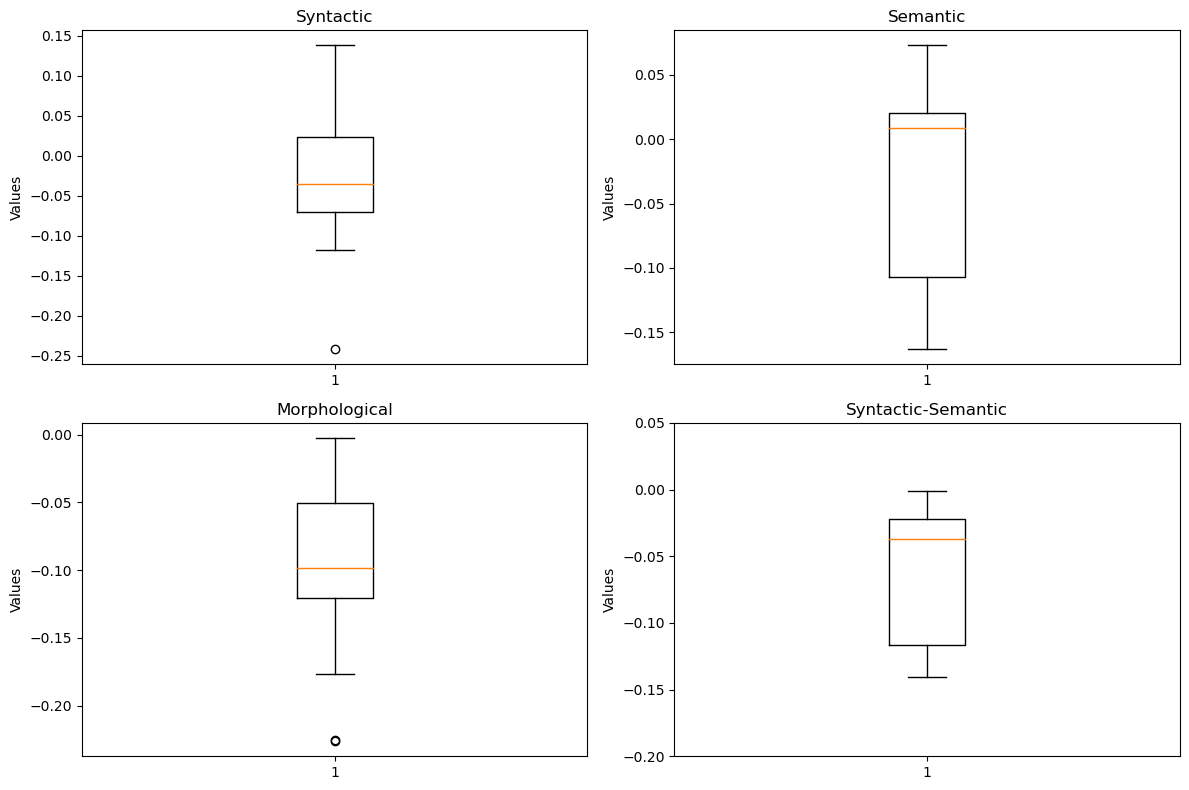

In [19]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the layout as necessary
axs = axs.flatten()  # Flatten the array of axes to make indexing easier
import numpy as np
# Plot each group
for idx, (key, values) in enumerate(data.items()):
    axs[idx].boxplot(values)
    match key:
        case 'sem':
            axs[idx].set_title('Semantic')
        case 'morp':
            axs[idx].set_title('Morphological')
        case 'synsem':
            axs[idx].set_title('Syntactic-Semantic')
        case 'syn':
            axs[idx].set_title('Syntactic')
    axs[idx].set_ylabel('Values')
    
    median = np.median(values)
    print(f"Key: {key}, Median: {median}")

plt.tight_layout()
plt.ylim(-0.20,0.05)
plt.show()
